# Selection of network depth and number of filters for the model

## Contents
* [Task description](#Task-description)
* [Model description](#Model-description)
* [The parameters studied](#The-parameters-studied)
* [Parameters Value Area](#Parameters-Value-Area)
* [Metrics](#Metrics)
* [Dataset loading](#Dataset-loading)
* [Creating a cross validation object](#Creating-a-cross-validation-object)
* [Results](#Results)
* [Conclusion](#Conclusion)

## Task description
Select the architecture parameters of CNN, that predicts radial mode value. This parameters will be selected using research and cross validation method.

## Model description

This is a small variation of ResNet architecture. The model consists following parameters:

3 standard ResNet blocks with max pooling at the start. Using layout notation one block can be written as `Rcna cna+` where:

* R - start residual connection
* `+` - end residual connection with summation

start number of parameters equal `8`.

max pooling parameters:
* pool_size = 3
* pool_stride = 2

parameters of each block:
* number of filters = [4, 8, 16]
* actiavtion = tf.relu
* kernel_size = 3
* strides = 2
* padding = 'same'

## The parameters studied
The order of the channels, number of initial filters, number of filters inside blocks.

## Parameters Value Area

Number of initial filters: [4, 8]

Number of filters inside blocks: [[4, 8, 16], [8, 16, 32]]

## Metrics

A percentage of items with absolute percentage error less than 30% on the test set i.e. `test_mape30`

## Dataset loading

For training and model performance assessment we use pressure derivative from wells.

Dataset consists of two parts: train (311 items) and test (90 items).

With cross validation approach we will mix all data and split it into peases for training and testing.

In [1]:
import os
import sys
sys.path.insert(0, os.path.join(".."))

import numpy as np
import matplotlib.pyplot as plt

from radial.batchflow import Dataset, FilesIndex, Pipeline, B, V, C
from radial.batchflow.models.tf import ResNet

from radial.batchflow.research import Research, Option

from radial.core.radial_batch_tools import get_mape30, save_model, get_ape
from radial.core import RadialBatch

from radial.pipelines import *

from research_utils import draw_history, draw_hisogram, print_results, \
                           create_datasets, execute_research_with_cv

plt.style.use('ggplot')
%matplotlib inline

In [2]:
cross_val = 3
path = "/path/to/data/isol/*"

dataset = create_datasets(path, RadialBatch, cross_val)

## Dataset bypass:

- Define batch and grid size
- Define model config

In [3]:
N_SAMPLES = 100
B_SIZE = 50


model_config = {
    'inputs': dict(points=dict(shape=(N_SAMPLES, 2)),
                   targets=dict(name='target', shape=1)),
    'initial_block/inputs': 'points',
    'head': dict(layout='f',
                 units=1),
    'body/num_blocks': [1, 1, 1],
    'body/filters': C('body_filters'),
    'initial_block/filters': C('start_filters'),
    'loss': 'mse',
    'optimizer': 'Adam'
}

- Define a preprocessing pipeline that will be shared between train and test pipelines
- Define train and test pipeline

In [4]:
prep_pipeline = create_preprocess_pipeline(N_SAMPLES, np.random.random)
train_pipeline = create_train_pipeline(C('model'), model_config,
                                       prep_pipeline).run(B_SIZE, n_epochs=None, 
                                                          drop_last=True, lazy=True)

test_pipeline = create_predict_pipeline(prep=prep_pipeline, 
                                        load_model=C('import_from')).run(B_SIZE, n_epochs=1, 
                                                                         drop_last=True,
                                                                         lazy=True)

## Creating a cross validation object

Cross validation algorithm depend on research object, so let's configurate it.

In [5]:
opts = Option('model', [ResNet]) \
       * Option('body_filters', [[4, 8, 16],
                                 [8, 16, 32]]) * Option('start_filters', [4, 8])

research = (Research()
            .pipeline(train_pipeline, variables='loss', name='train')
            .pipeline(test_pipeline, name='test', execute='%5',
                      run=True, import_from='train')
            .grid(opts)
            .function(get_mape30, returns='metrics', name='test_mape30',
                      execute='%5', pipeline='test')
            .function(get_ape, returns='metrics', name='test_ape',
                     execute=-1, pipeline='test')
            .function(save_model, execute=-1, pipeline='train',
                      model_name='model', path='saved_models/')
)

Now you can run the cross validation.

In [6]:
res = execute_research_with_cv(train_pipeline, test_pipeline, research,
                               dataset, n_reps=3, n_iters=1500, 
                               cross_val=cross_val, dir_name='research_resnets')

## Results

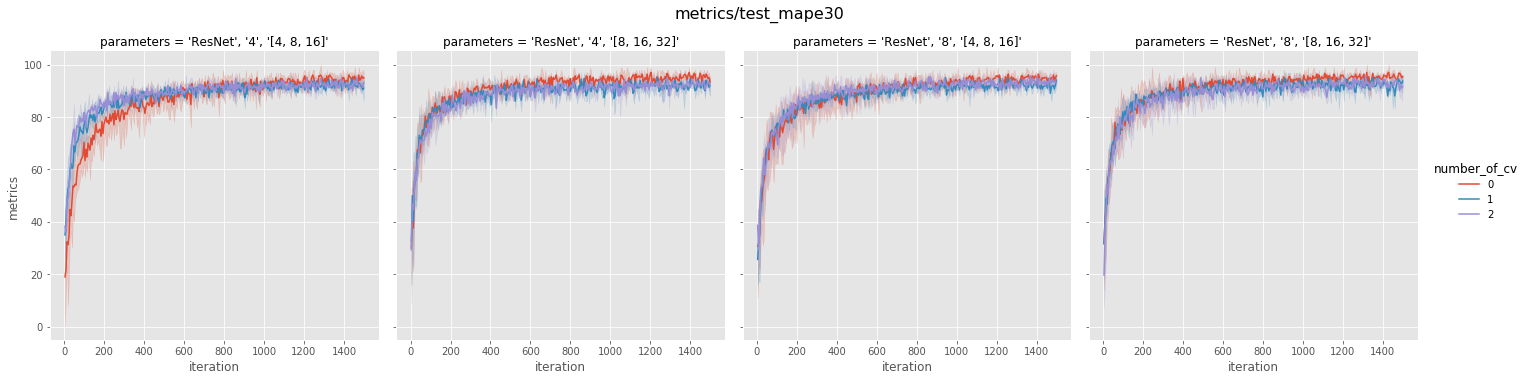

In [7]:
draw_history(research='research_resnets/', names=['test_mape30'], types_var=['metrics'],
             cross_val=cross_val, aggr=False, iter_start=1, draw_dict=None)

In [8]:
for i in range(3):
    print('{} fold of cross validation'.format(i))
    print_results(research='research_resnets/research_cv_{}/'.format(i), names=['test_mape30'],
                  types_var=['metrics'], draw_dict=None)

0 fold of cross validation
╒══════════════════════════════╤═══════════════╤═══════════════════╕
│ params                       │   test_mape30 │   test_mape30 std │
╞══════════════════════════════╪═══════════════╪═══════════════════╡
│ 'ResNet', '4', '[8, 16, 32]' │       94.7267 │          0.760804 │
├──────────────────────────────┼───────────────┼───────────────────┤
│ 'ResNet', '4', '[4, 8, 16]'  │       93.8533 │          1.85448  │
├──────────────────────────────┼───────────────┼───────────────────┤
│ 'ResNet', '8', '[4, 8, 16]'  │       94.3333 │          1.10708  │
├──────────────────────────────┼───────────────┼───────────────────┤
│ 'ResNet', '8', '[8, 16, 32]' │       94.9567 │          0.643653 │
╘══════════════════════════════╧═══════════════╧═══════════════════╛
1 fold of cross validation
╒══════════════════════════════╤═══════════════╤═══════════════════╕
│ params                       │   test_mape30 │   test_mape30 std │
╞══════════════════════════════╪═══════════════╪═

## Conclusion

As we can see on the test_mape30 graphic, the best model is the one with the number of filers in block = [4, 8, 16] and number of initial finters = 8. This model shows the best MAPE value with small std value in 2 of 3 cases.

Despite the fact that the chosen configuration of the model was on average better than others, it is useful, along with a point estimate, to obtain the distribution of the metric over N independent runs of the training procedure.

Firstly we should reconstruct pipelines with optimal parameters.

In [9]:
ds_train = Dataset(FilesIndex(path="/path/to/data/isol/*"), batch_class=RadialBatch)
ds_test = Dataset(FilesIndex(path="/path/to/data/isol/*"), batch_class=RadialBatch)

model_config['body/filters'] = [4, 8, 16]
model_config['initial_block/filters'] = 8

train_pipeline = create_train_pipeline(ResNet, model_config,
                                       prep_pipeline).run(B_SIZE, n_epochs=None, 
                                                          drop_last=True, lazy=True)
test_pipeline = create_predict_pipeline(prep=prep_pipeline, 
                                        load_model=train_pipeline).run(B_SIZE, n_epochs=1, 
                                                                       drop_last=True, lazy=True)

train_pipeline = train_pipeline << ds_train
test_pipeline = test_pipeline << ds_test

After it we can create a Research instance.

In [10]:
opts = Option('model', [ResNet]) * Option('body_filters', [[4, 8, 16]]) * Option('filters', [8])

research = (Research()
            .pipeline(train_pipeline, variables='loss', name='train')
            .pipeline(test_pipeline, name='test', execute='%5',
                      run=True, import_from='train')
            .grid(opts)
            .function(get_mape30, returns='metrics', name='test_mape30',
                     execute='%5', pipeline='test')
            .function(get_ape, returns='metrics', name='test_ape',
                     execute=-1, pipeline='test')
            .function(save_model, execute=-1, pipeline='train',
                      model_name='model', path='saved_models/')
)

In [11]:
NUM_REPEAT = 10
NUM_ITERS = 1200
research_name = 'model_estimation'

research.run(n_reps=NUM_REPEAT, n_iters=NUM_ITERS, name=research_name, progress_bar=True)

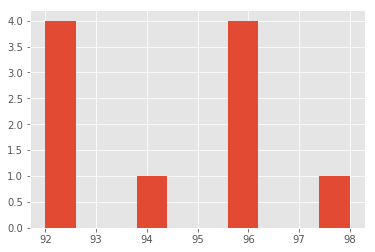

In [12]:
res_table = Research().load('model_estimation/').load_results()
maximum = np.max(res_table['iteration'])
all_metrics = np.array(res_table[res_table['iteration']==maximum]
                       [res_table['name']=='test_mape30']['metrics'], dtype=np.float32)
plt.hist(all_metrics)
plt.show()

In [13]:
print_results(research='model_estimation/', names=['test_mape30'],
              types_var=['metrics'], n_last=50)

╒══════════╤═══════════════╤═══════════════════╕
│ params   │   test_mape30 │   test_mape30 std │
╞══════════╪═══════════════╪═══════════════════╡
│          │        91.932 │             0.564 │
╘══════════╧═══════════════╧═══════════════════╛


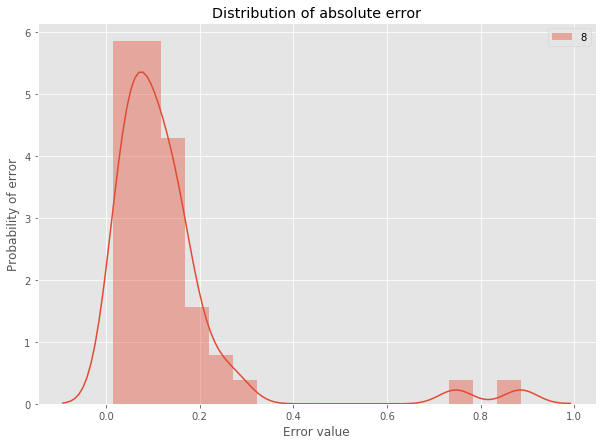

In [14]:
draw_hisogram(research='./model_estimation/', names='test_ape',
              type_var='metrics', cross_val=None)